In [18]:
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
!pip install --user matplotlib==3.5.2

In [2]:
import matplotlib
print("Matplotlib version:", matplotlib.__version__)

Matplotlib version: 3.5.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

import csv

%matplotlib inline

In [3]:
# use original Sentinel-1 SAR files (download from colhub.met.no)

f1 = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/safe/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB.SAFE'
f2 = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/safe/S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014.SAFE'
# create Nansat objects with one band only. 
n1 = get_n(f1, bandName='sigma0_HV', remove_spatial_mean=True) 
n2 = get_n(f2, bandName='sigma0_HV', remove_spatial_mean=True) 

VMIN:  -3.9498636960983275
VMAX:  5.663959283828735
VMIN:  -3.5571017265319824
VMAX:  5.484246134757996


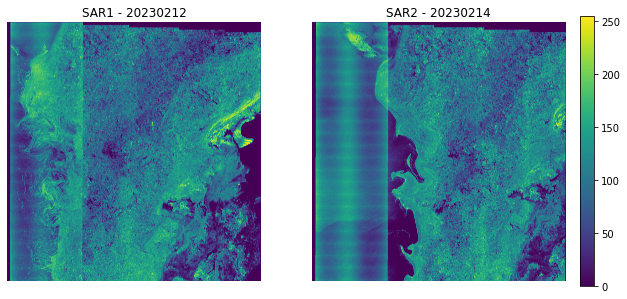

In [4]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
im1 = ax[0].imshow(n1[1], clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(n2[1], clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im2, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1 - 20230212")
ax[1].set_title("SAR2 - 20230214")

plt.show()

In [5]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 37701
Domain filter: 50000 -> 48850
Keypoints matched 3.8521876335144043
Ratio test 0.600000 found 1552 keypoints
MaxDrift filter: 1552 -> 1552
LSTSQ filter: 1552 -> 1523


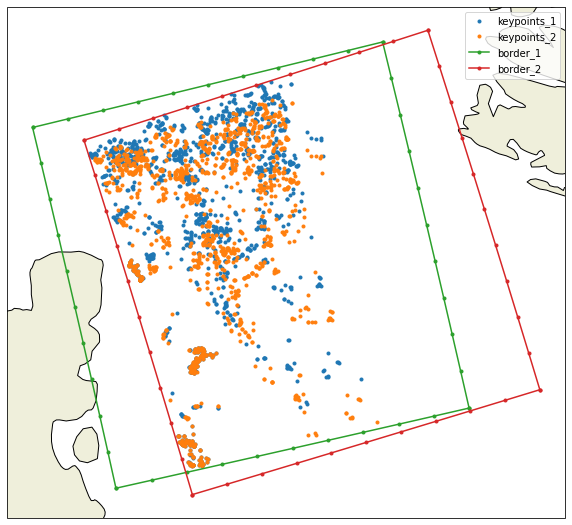

In [6]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

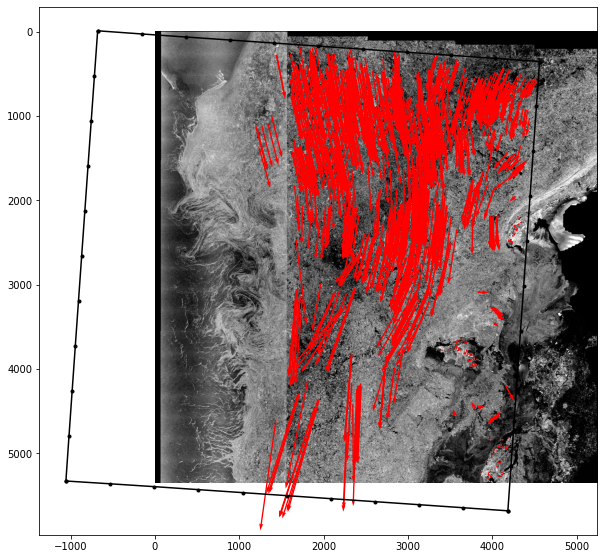

In [7]:

# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')

plt.show()
#filename = '/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/FT_example_HH#_1image.png'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

In [8]:
import xarray as xr
data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230901T00Z.nc")

In [9]:
import xarray as xr
# Setting subset grid using image border coordinates from nanset object
# Open the remote dataset with model data
#data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T18Z.nc")
# Extract X and Y coordinates, as well as longitude and latitude values from the dataset
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']

# Retrieve the proj4 string defining the Lambert Conformal projection of the dataset
proj4 = data.projection_lambert.proj4
print(proj4)

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

#Get bound in rows and columns correspoding to the image borders set above
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min_row, max_row, min_col, max_col = min(r), max(r), min(c), max(c)

+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06


In [10]:
conc1 = data.ice_concentration.sel(time = '2023-02-14T08:00:00', ensemble_member = data.ensemble_member[0])

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
conc6_mean = data.ice_concentration.sel(time = '2023-02-14T08:00:00').mean(dim='ensemble_member')

In [11]:
%store min_row
%store max_row
%store min_col
%store max_col
%store lon
%store lat

Stored 'min_row' (int64)
Stored 'max_row' (int64)
Stored 'min_col' (int64)
Stored 'max_col' (int64)
Stored 'lon' (DataArray)
Stored 'lat' (DataArray)


In [12]:
# Extract the subset grif out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [13]:
%store X_subset
%store Y_subset

Stored 'X_subset' (DataArray)
Stored 'Y_subset' (DataArray)


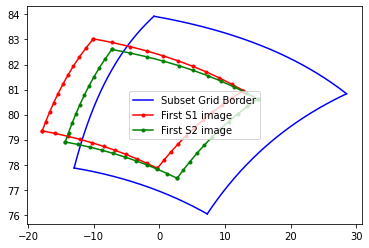

In [14]:
# Plot coverage of the first SAR1 image and subset grid imported from the model
# Top border
plt.plot(lon_subset[0, :], lat_subset[0, :], 'b-', label='Subset Grid Border')
# Bottom border
plt.plot(lon_subset[-1, :], lat_subset[-1, :], 'b-')
# Left border
plt.plot(lon_subset[:, 0], lat_subset[:, 0], 'b-')
# Right border
plt.plot(lon_subset[:, -1], lat_subset[:, -1], 'b-')

plt.plot(*n1.get_border(), '.-', label='First S1 image', c = 'red')
plt.plot(*n2.get_border(), '.-', label='First S2 image', c = 'green')
#plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [15]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=200,
                                                           max_border=200,
                                                           angles=[-15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15])

100% 02082.5 00080.3 0000nan 0000nan +0nan 0nan 0nan
 Pattern matching - OK! (210 sec)


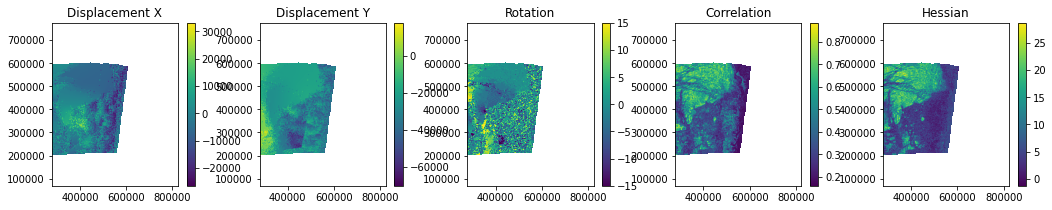

In [16]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
    plt.colorbar(im, ax=ax[i])

plt.show()

In [17]:
# Model domain to reproject SAR image from 3996
model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')
# reproject n1 for visualizing SAR image in the same projection as model data

# Get n for vizualizaton and reprojecting
n1.reproject(model_d) #n1.export
n1b1 = n1[1]
n1.undo()

#### Plotting data with hessian

In [18]:
# Export total time differencr for speed calculation
%store -r total_time_diff
total_time_diff

171820

Number of True values without filtering : 8205


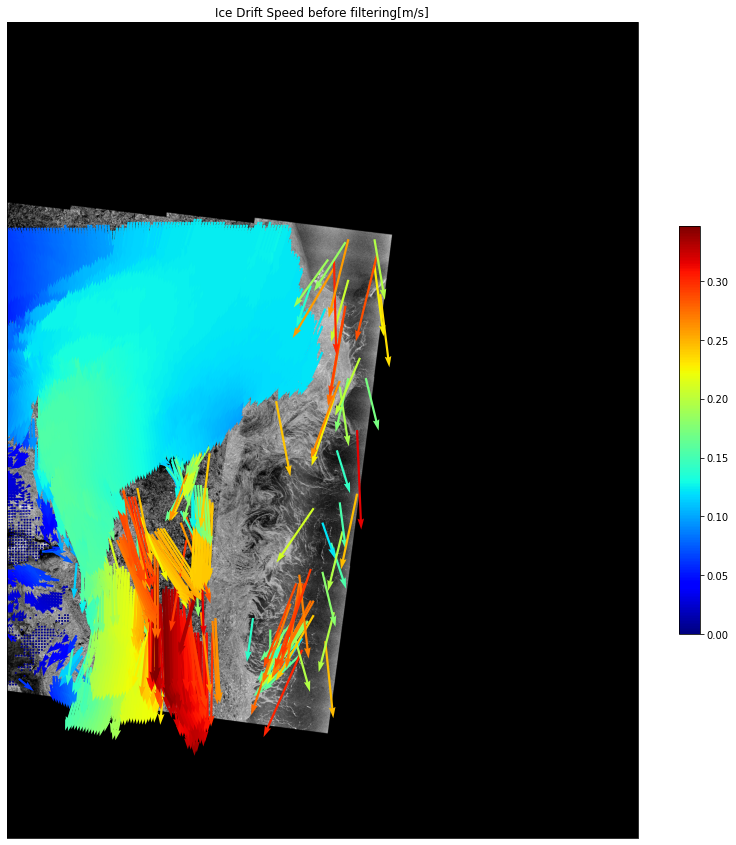

In [19]:
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
plt.figure(figsize=(15,15))
ax =plt.axes(projection=crs) 

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")

# Plot the image on the first subplot
#
ax.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
#quiv1 = ax.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=5, cmap='jet', width=0.0035)
quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax.set_title('Ice Drift Speed before filtering[m/s]')
#ax.add_feature(land_50m, edgecolor='black')
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.colorbar(quiv1, ax=ax, orientation='vertical', shrink=0.5)


plt.show()


In [21]:
gpi_sar1_sar2 = gpi
%store gpi_sar1_sar2

Stored 'gpi_sar1_sar2' (ndarray)


##### Filtering with concentration

In [20]:
# Concentration at the start of the time period is used as it is corresponding to the situation where vector starts from
%store -r feb1214_conc

Number of True values in gpi before filtering: 7808
Number of True values in gpi after filtering: 7733


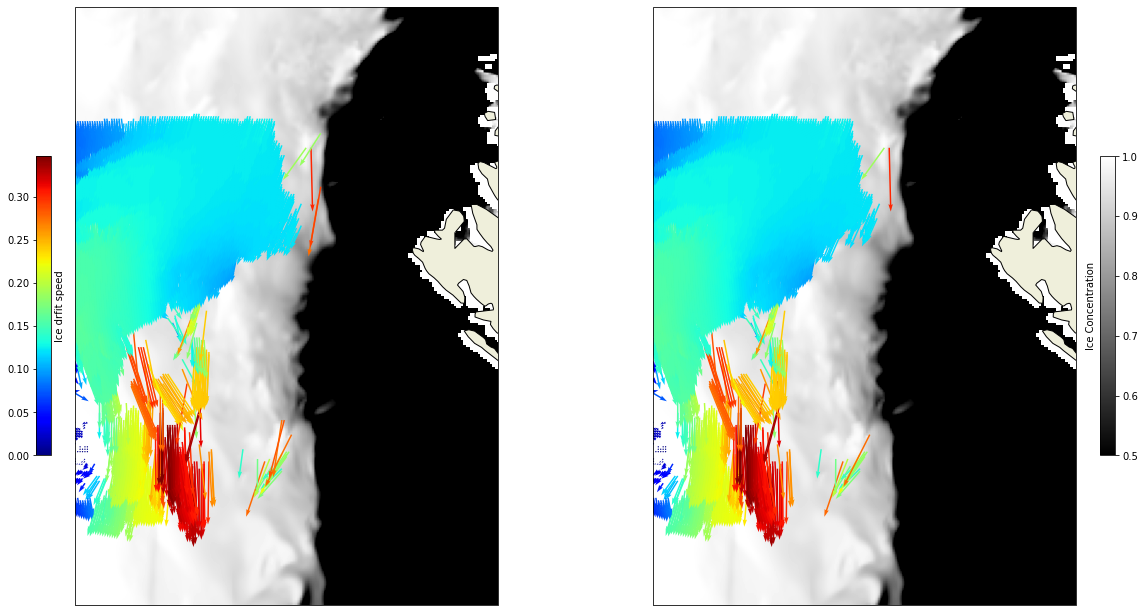

In [36]:
# without steps for visualizing 
dayssec = total_time_diff
siconc_subset  = feb1214_conc[min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 9)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")
# plot concentration
conc_img = ax1.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
# plot every n_th vector
#quiv=ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035)
quiv=ax1.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035) 
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])

#  Figure 2

# filter vectors with hessian value and concentration
gpi = (hpm > 9)*(siconc_subset > 0.9)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi after filtering: {num_true_values}")
# plot concentration
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='gray', alpha=1, vmin=0.5, vmax=1)
#plot every n_th vector
#quiv=ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035)
quiv=ax2.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1],speed[gpi][::1], scale=2, cmap='jet',width=0.0035) 
cbar1 = plt.colorbar(quiv,ax=ax1, label='Ice drfit speed', location='left', shrink=0.5, pad=0.04)
cbar1.ax.yaxis.set_label_position('right')
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
#plt.title('Ice drfit speed [m/s]')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
# colorbar for the concentration
cbar2 = plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', location='right', shrink=0.5, pad=0.04)
cbar2.ax.yaxis.set_label_position('left')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



##### Exporting data

In [35]:
'''
# I cahnged it to saving as scv
%store upm
%store vpm
%store apm
%store rpm
%store hpm
%store lon2pm
%store lat2pm
%store lon1pm
%store lat1pm
'''
gpi_1416_02 = gpi
%store gpi_1416_02
shape = upm.shape
%store shape

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'apm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'hpm' (ndarray)
Stored 'lon2pm' (ndarray)
Stored 'lat2pm' (ndarray)
Stored 'lon1pm' (ndarray)
Stored 'lat1pm' (ndarray)
Stored 'gpi_1416_02' (ndarray)
Stored 'shape' (tuple)


In [37]:
#Prepare data for export

#Replace inf with nan. It seems that lat2, lon2 sometimes get inf and it effects u and v
#then it gives errors in alignment algortihm
infu = np.where(np.isinf(upm))
infv = np.where(np.isinf(vpm))
upm[infu] = np.nan
vpm[infv] = np.nan

In [38]:
x1pm.shape, lon1pm.shape

((283, 219), (283, 219))

In [26]:
#EXPORTING DRIFT POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees (v and u - displacement, to calculate speed use delta_t)

lon1_flat, lat1_flat, lon2_flat,lat2_flat = lon1pm.flatten(),lat1pm.flatten(), lon2pm.flatten(),lat2pm.flatten()
x1pm_flat, y1pm_flat = x1pm.flatten(),  y1pm.flatten()
#delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
#u = upm / delta_t
#v = vpm / delta_t

u_flat, v_flat, a_flat, r_flat, h_flat, gpi_flat = upm.flatten(), vpm.flatten(), apm.flatten(), rpm.flatten(), hpm.flatten(), gpi.flatten()

In [28]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, x1pm_flat, y1pm_flat, u_flat, v_flat, a_flat, r_flat, h_flat)

header=['lon1','lat1', 'lon2','lat2', 'x', 'y', 'u','v', 'a','r', 'h']

with open("/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_algorithm_disp_14-16feb.csv",'w') as f: 
    out = csv.writer(f, delimiter=',')
    out.writerow(header) 
    out.writerows(points)

In [40]:
# Only for filtered points (filteres with gpi)
#EXPORTING DRIFT POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees (v and u - displacement, to calculate speed use delta_t)

lon1_flat, lat1_flat, lon2_flat,lat2_flat = lon1pm[gpi].flatten(),lat1pm[gpi].flatten(), lon2pm[gpi].flatten(),lat2pm[gpi].flatten()

#delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
#u = upm / delta_t
#v = vpm / delta_t

u_flat, v_flat, a_flat, r_flat, h_flat, gpi_flat = upm[gpi].flatten(), vpm[gpi].flatten(), apm[gpi].flatten(), rpm[gpi].flatten(), hpm[gpi].flatten(), gpi.data.flatten()

In [89]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, u_flat, v_flat, a_flat, r_flat, h_flat)

header=['lon1','lat1', 'lon2','lat2', 'u','v', 'a','r', 'h']

with open("/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_algorithm_gpi_disp_14-16feb.csv",'w') as f: 
    out = csv.writer(f, delimiter=',')
    out.writerow(header) 
    out.writerows(points)

In [41]:
#Exporting for Chalmers

points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat)

header=['lon1','lat1', 'lon2','lat2']

with open("/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_alg_disp_for_chalmers_14-16feb_gpi.csv",'w') as f: 
    out = csv.writer(f, delimiter=',')
    out.writerow(header) 
    out.writerows(points)